# Loading Data


In [1]:
# Load the Data
import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})


# clean_data = clean_data.drop(['ID','Subjectivity', 'Sentiment Polarity', 'Sarcasm', 'Irony', 'Negation'], axis=1)
clean_data = clean_data.drop(['ID'], axis=1)

clean_data.head()
clean_data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
5068,"Wow growing together, so I will get a 17 black...",1,positive,disgust,0,1,0
5069,Equal pay for equal work to be introduced in t...,1,positive,anticipation,0,0,1
5070,No cash when worth more then 10000?. Use offsh...,1,negative,anticipation,0,1,0
5071,"Budget 2020 reactions: Some say it’s good, oth...",1,negative,anger,0,0,0
5072,"Budget 2020 reactions: Some say it’s good, oth...",1,neutral,sadness,0,0,0


# General Preprocessing

In [2]:
# Handle text processing and tokenisation:

import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Raw_Text'] = processed_data['Text']

processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,Raw_Text,tokens,padded,masks
0,great budget even cigarette touched great work...,1,positive,trust,0,0,1,Great BUDGET . Even cigarettes were not touche...,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,I haven't exactly scanned the budget throughou...,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,There’s already smoking cessation programs for...,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,So should alcohol and fuel for private vehicle...,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,practical say third world country supposed eur...,1,negative,anger,0,0,1,Practical? You should say that in a third worl...,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


# Lexicon Based Features 

In [3]:
# Punctuation Counts
import re
import pandas as pd

def count_punctuation(text, tokens):
    exclamation_count = len(re.findall(r'!', text))
    question_count = len(re.findall(r'\?', text))
    ellipsis_count = len(re.findall(r'\.\.\.', text))
    comma_count = len(re.findall(r',', text))
    period_count = len(re.findall(r'\. ', text))
    token_count = len(tokens)
    if token_count == 0:
        token_count = 1
    return pd.Series({
        'exclamation_count': exclamation_count,
        'question_count': question_count,
        'ellipsis_count': ellipsis_count,
        'comma_count': comma_count,
        'period_count': period_count,
        'exclamation_score': exclamation_count / token_count,
        'question_score': question_count / token_count,
        'ellipsis_score': ellipsis_count / token_count,
        'comma_score': comma_count / token_count,
        'period_score': period_count / token_count
    })

processed_data = processed_data.join(
    processed_data.apply(lambda row: count_punctuation(row['Raw_Text'], row['tokens']), axis=1)
)
    
processed_data.head

<bound method NDFrame.head of                                                    Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive   

In [4]:
# Polarity 
nrc_lexicon_path = '../Lexicons/NRC/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = pd.read_csv(nrc_lexicon_path, sep='\t', header=None, names=['word', 'emotion', 'association'])

# Get pos and neg words
positive_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'positive') & (nrc_lexicon['association'] == 1)]['word'].tolist()
negative_words = nrc_lexicon[(nrc_lexicon['emotion'] == 'negative') & (nrc_lexicon['association'] == 1)]['word'].tolist()

def count_polarity_words(tokens, positive_words, negative_words):
    pos_count = 0
    neg_count = 0
    for token in tokens:
        if token in positive_words:
            pos_count +=1 
        if token in negative_words:
            neg_count +=1
            
    return pos_count, neg_count

processed_data[['pos_count', 'neg_count']] = processed_data['tokens'].apply(
    lambda x: pd.Series(count_polarity_words(x, positive_words, negative_words))
    )

print(processed_data)

                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [5]:
from afinn import Afinn

afinn = Afinn()
processed_data['afinn_count'] = processed_data['Raw_Text'].apply(lambda x: afinn.score(x))

print(processed_data)


                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [6]:
#objectivity scores 
nltk.download('sentiwordnet')
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

def get_sentiwordnet_scores(tokens):
    score = 0
    for token in tokens:
        synsets = wn.synsets(token)
        if not synsets:
            continue  # No synset found for the word

        synset = synsets[0]  # Take the first synset
        swn_synset = swn.senti_synset(synset.name())
        score += swn_synset.obj_score()
    if len(tokens) == 0: ## if there are no tokens, then assume objective
        return 1.0
    return score / len(tokens)

processed_data['obj_score'] = processed_data['tokens'].apply(lambda tokens: get_sentiwordnet_scores(tokens)) 

print(processed_data)

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


                                                   Text  Subjectivity  \
0     great budget even cigarette touched great work...             1   
1     exactly scanned budget throughout earth make i...             1   
2     already smoking cessation program people want ...             1   
3     alcohol fuel private vehicle raising tax cigar...             1   
4     practical say third world country supposed eur...             1   
...                                                 ...           ...   
5068              wow growing together get black budget             1   
5069  equal pay equal work introduced private sector...             1   
5070                    cash worth use offshore account             1   
5071  budget reaction say good others say bad earnes...             1   
5072  budget reaction say good others say bad happen...             1   

     Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0              positive         trust        0      0   

In [7]:
# Normalise any counts and rename to be scores

count_columns = [col for col in processed_data.columns if col.endswith('_count')]

for col in count_columns:
    score_col = col.replace('_count', '_score') 
    processed_data[score_col] = processed_data[col] / processed_data['tokens'].apply(len)

print(processed_data.head())
print(processed_data.columns)

                                                Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

  Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0           positive         trust        0      0         1   
1           negative       disgust        0      0         1   
2            neutral  anticipation        0      0         0   
3           negative       sadness        0      0         0   
4           negative         anger        0      0         1   

                                            Raw_Text  \
0  Great BUDGET . Even cigarettes were not touche...   
1  I haven't exactly scanned the budget throughou...   
2  There’s already smoking

In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def extract_vader_features(text):
    sentiment = sia.polarity_scores(text)
    return pd.Series({
        'vader_neg': sentiment['neg'],
        'vader_neu': sentiment['neu'],
        'vader_pos': sentiment['pos'],
        'vader_compound': sentiment['compound']
    })

# Apply the function to your DataFrame
vader_features = processed_data['Raw_Text'].apply(extract_vader_features)

# Concatenate the new VADER features with the original DataFrame
processed_data = pd.concat([processed_data, vader_features], axis=1)

# Display the updated DataFrame
print(processed_data.head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                                Text  Subjectivity  \
0  great budget even cigarette touched great work...             1   
1  exactly scanned budget throughout earth make i...             1   
2  already smoking cessation program people want ...             1   
3  alcohol fuel private vehicle raising tax cigar...             1   
4  practical say third world country supposed eur...             1   

  Sentiment Polarity       Emotion  Sarcasm  Irony  Negation  \
0           positive         trust        0      0         1   
1           negative       disgust        0      0         1   
2            neutral  anticipation        0      0         0   
3           negative       sadness        0      0         0   
4           negative         anger        0      0         1   

                                            Raw_Text  \
0  Great BUDGET . Even cigarettes were not touche...   
1  I haven't exactly scanned the budget throughou...   
2  There’s already smoking

# Computational Feature engineering 

In [9]:
# Polarity. 

from tqdm import tqdm
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

# Load sentiment analysis pipeline
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

def get_sentiment(tokens):
    total_score = 0
    result = sentiment_analyzer(tokens)
    if len(result) == 0:
        return 0.0
    for r in result:
        total_score += r['score']
    return total_score / len(result)

processed_data['polarity_score'] = processed_data['tokens'].apply(get_sentiment)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [10]:
# Subjectivity

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification
import torch
import logging

loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
for logger in loggers:
    if "transformers" in logger.name.lower():
        logger.setLevel(logging.ERROR)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
bert_model = BertModel.from_pretrained("cffl/bert-base-styleclassification-subjective-neutral")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize and convert to BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

X = get_bert_embeddings(processed_data['Text'])
y = processed_data['Subjectivity']

# Train SVM classifier
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))
clf.fit(X, y)

# Get the decision function values or probabilities
subjectivity_probabilities = clf.predict_proba(X)

# Assuming binary classification, we take the probability of the positive class (index 1)
processed_data['subjectivity_score'] = subjectivity_probabilities[:, 1]

In [11]:
# Sarcasm detection using BERT and LSTM

import torch
import torch.nn as nn


class SarcasmLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim, num_layers):
        super(SarcasmLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(bert_model.config.hidden_size, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        with torch.no_grad():
            bert_output = self.bert(**inputs).last_hidden_state
        lstm_output, _ = self.lstm(bert_output)
        logits = self.fc(lstm_output[:, -1, :])
        return self.sigmoid(logits)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
bert_model = BertModel.from_pretrained("nikesh66/Sarcasm-Detection-using-BERT")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')

# Initialize the LSTM model
sarcasm_model = SarcasmLSTM(bert_model, hidden_dim=256, output_dim=1, num_layers=2)

# Tokenize and predict sarcasm for the entire dataset
inputs = tokenizer(processed_data['Text'].tolist(), return_tensors='pt', padding=True, truncation=True)
with torch.no_grad():
    sarcasm_prob = sarcasm_model(inputs).numpy()

processed_data['sarcasm_score'] = sarcasm_prob.flatten()  # Keep the raw probability

In [12]:
# Irony

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import pandas as pd

# Load the fine-tuned RoBERTa model and tokenizer for irony detection
tokenizer = AutoTokenizer.from_pretrained("vikram71198/roberta-base-finetuned-irony")
roberta_model = AutoModelForSequenceClassification.from_pretrained("vikram71198/roberta-base-finetuned-irony")

# Function to get predictions directly from the RoBERTa model
def detect_irony(texts):
    # Tokenize the input texts
    inputs = tokenizer(texts.tolist(), return_tensors='pt', padding=True, truncation=True)
    
    # Get model predictions
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    
    # Convert logits to probabilities
    probabilities = torch.softmax(outputs.logits, dim=-1)
    
    # The model returns a probability for each class (ironic or not ironic)
    # Assuming binary classification (ironic vs. not ironic), we take the probability for the 'ironic' class
    irony_scores = probabilities[:, 1].numpy()  # Index 1 is usually for the positive class
    
    return irony_scores

# Assume processed_data is your DataFrame containing a 'Text' column
# Get irony_scores for each text in the DataFrame
processed_data['irony_score'] = detect_irony(processed_data['Text'])

In [13]:
processed_data = processed_data.dropna()

# processed_data = processed_data.drop(columns=['exclamation_score', 'question_score', 'ellipsis_score', 'anger_score','disgust_score','surprise_score','anger_tei','fear_tei','surprise_tei','surprise_mei','anger_gec_0.75','sadness_gei_0.75','subjectivity_score'])
# These columns were manually identified as having poor distribution.

# Feature examination

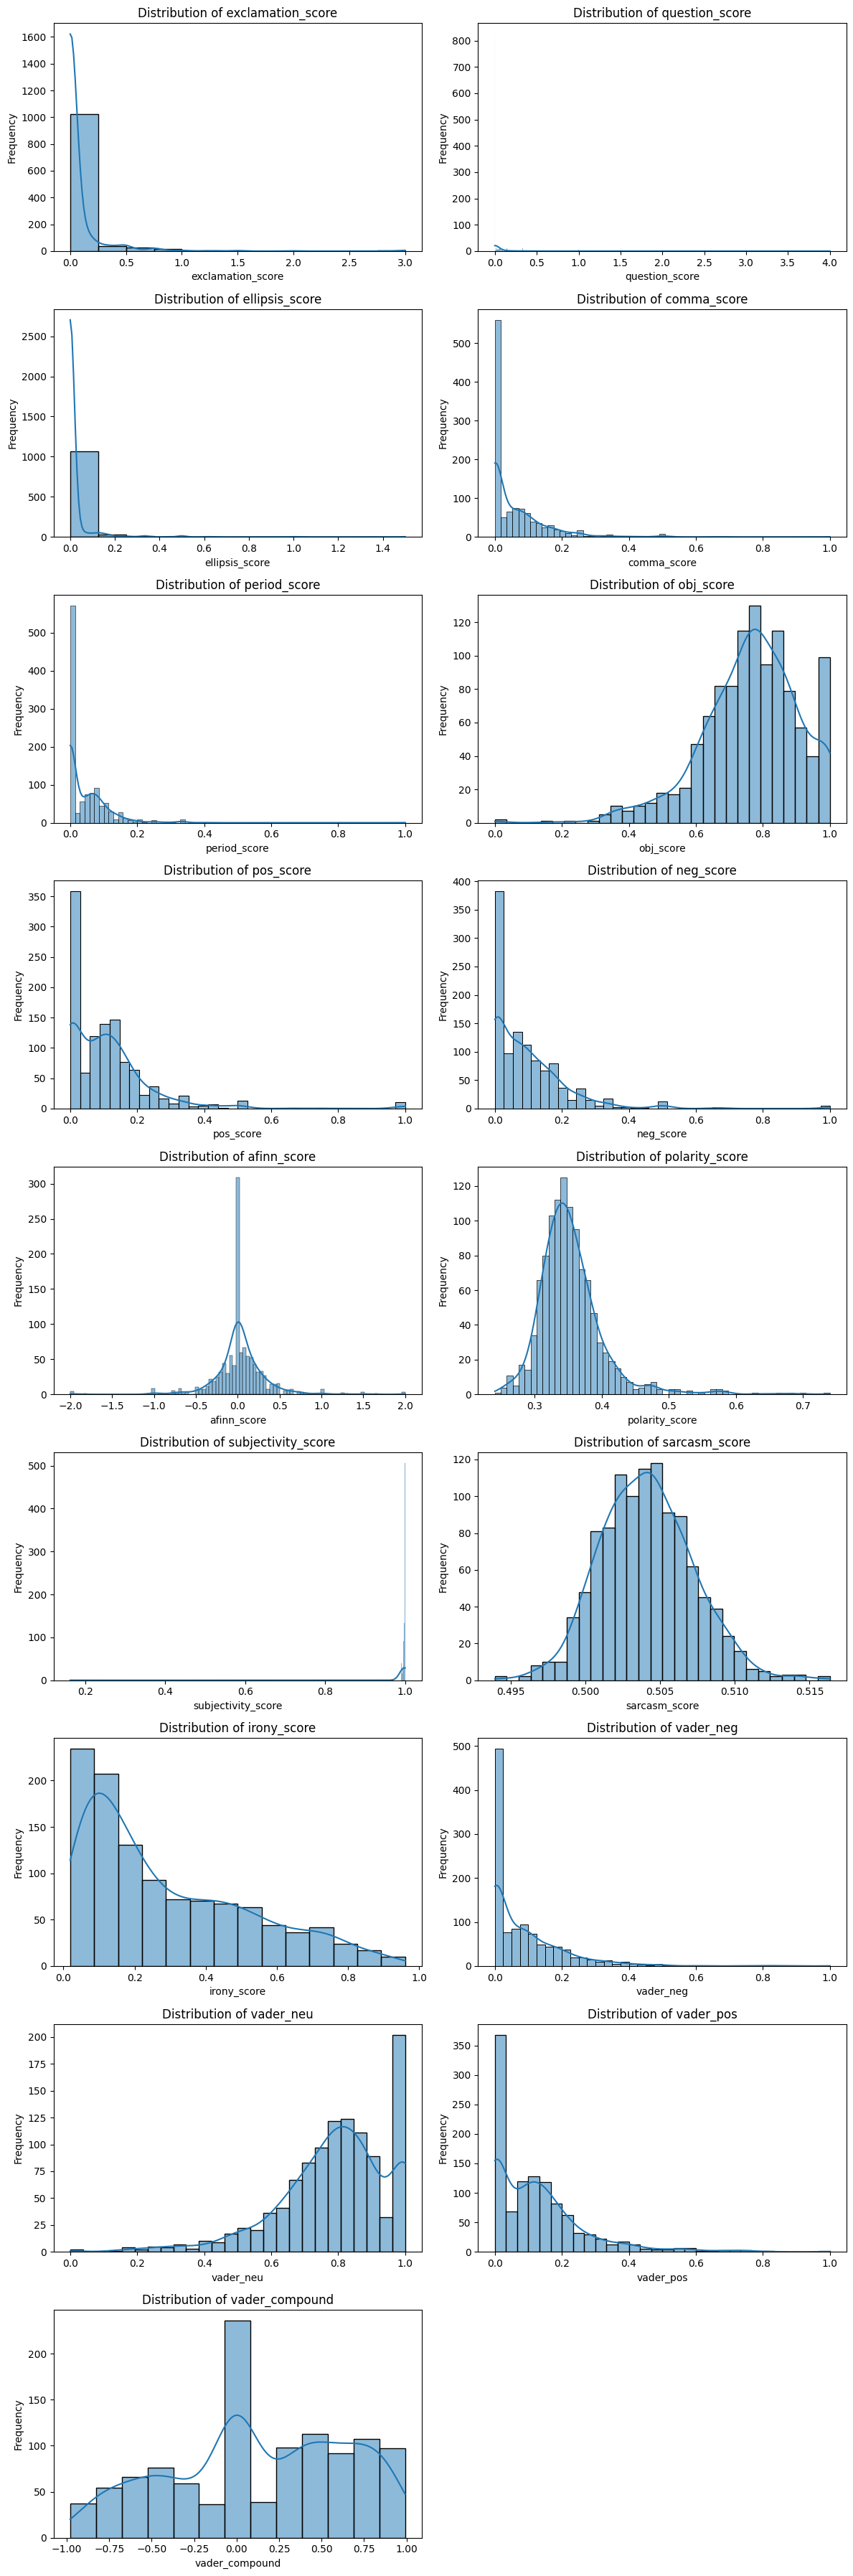

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# List of features to plot (using suffixes to include TEC, TEI, MEI, GEC, GEI)
feature_columns = [col for col in processed_data.columns if any(suffix in col for suffix in ['_score'])]
feature_columns = feature_columns + ['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']

# Determine number of rows needed (2 columns per row)
n_features = len(feature_columns)
n_rows = math.ceil(n_features / 2)

# Create subplots with 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows * 4))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Plot each feature's histogram in the grid
for i, feature in enumerate(feature_columns):
    sns.histplot(processed_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove unused subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

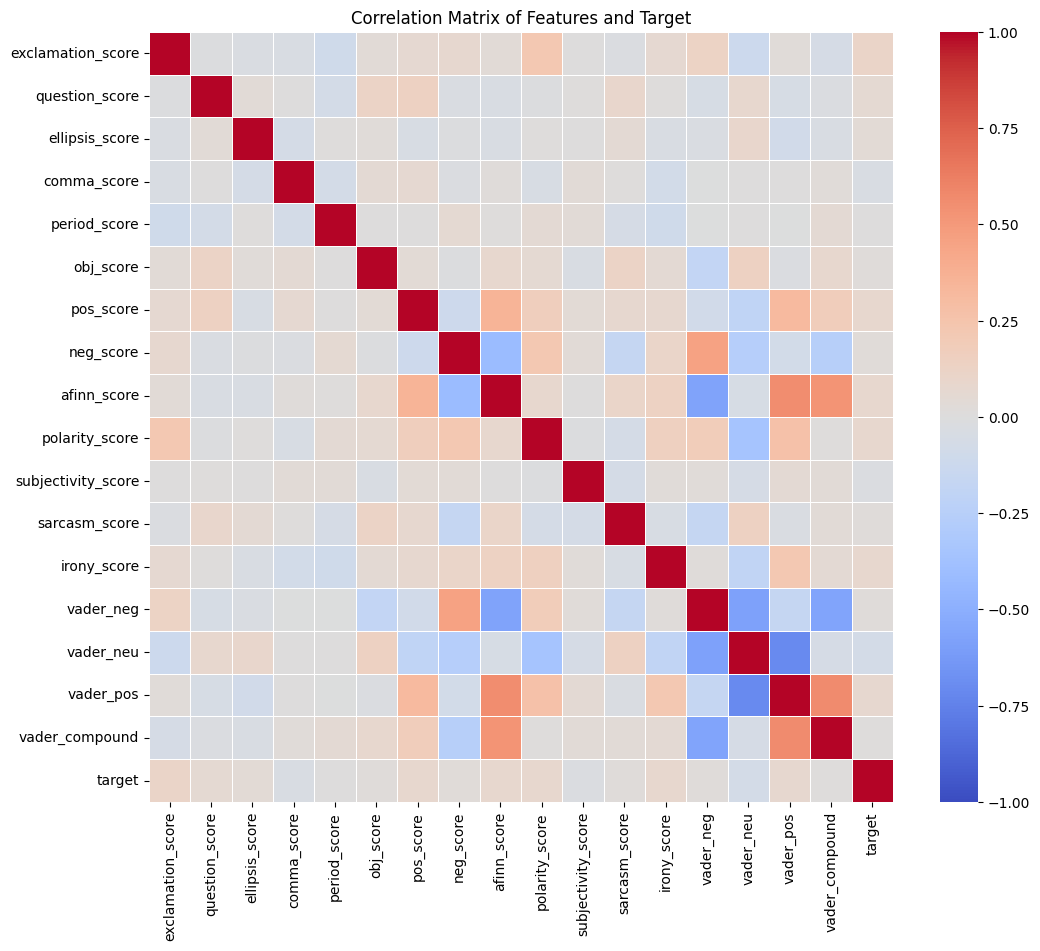

In [36]:
mapping_dict = {value: index for index, value in enumerate(processed_data['Emotion'].unique())}
processed_data['target'] = processed_data['Emotion'].map(mapping_dict)

correlation_data = processed_data[feature_columns + ['target']]

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features and Target')
plt.show()

# Feature Selection

In [16]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def featureSelection(n_features_to_select):
    # Assuming 'target' is your dependent variable and the feature columns are independent variables
    X = processed_data[feature_columns]
    y = processed_data['target']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize Logistic Regression
    model = LogisticRegression(max_iter=2000)

    # RFE for feature selection
    rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)  # You can change the number of features
    rfe.fit(X_train, y_train)

    # Print the selected features
    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    # Make predictions with selected features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Fit and predict
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)

    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features: {accuracy}")

In [17]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['exclamation_score', 'vader_neu']
Model accuracy with selected features: 0.25675675675675674
Selected Features:  ['exclamation_score', 'question_score', 'vader_neu']
Model accuracy with selected features: 0.26126126126126126
Selected Features:  ['exclamation_score', 'question_score', 'afinn_score', 'vader_neu']
Model accuracy with selected features: 0.2972972972972973
Selected Features:  ['exclamation_score', 'question_score', 'obj_score', 'afinn_score', 'vader_neu']
Model accuracy with selected features: 0.3108108108108108
Selected Features:  ['exclamation_score', 'question_score', 'obj_score', 'afinn_score', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.3153153153153153
Selected Features:  ['exclamation_score', 'question_score', 'obj_score', 'afinn_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.3063063063063063
Selected Features:  ['exclamation_score', 'question_score', 'ellipsis_score', 'obj_score', '

In [18]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def featureSelection(n_features_to_select):
# Assuming 'target' is your dependent variable and the feature columns are independent variables
    X = processed_data[feature_columns]
    y = processed_data['target']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize an SVM model with a linear kernel (suitable for RFE)
    svm_model = SVC(kernel='linear')

    # RFE for feature selection
    rfe = RFE(estimator=svm_model, n_features_to_select=n_features_to_select)  # Select the top 5 features, adjust as needed
    rfe.fit(X_train, y_train)

    # Get the selected features
    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    # Transform the train and test data to only use selected features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Fit the SVM model on the selected features
    svm_model.fit(X_train_rfe, y_train)

    # Make predictions
    y_pred = svm_model.predict(X_test_rfe)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features: {accuracy}")

In [19]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['vader_neg', 'vader_neu']
Model accuracy with selected features: 0.26126126126126126
Selected Features:  ['question_score', 'vader_neg', 'vader_neu']
Model accuracy with selected features: 0.25225225225225223
Selected Features:  ['exclamation_score', 'question_score', 'vader_neg', 'vader_neu']
Model accuracy with selected features: 0.26576576576576577
Selected Features:  ['exclamation_score', 'question_score', 'afinn_score', 'vader_neg', 'vader_neu']
Model accuracy with selected features: 0.2702702702702703
Selected Features:  ['exclamation_score', 'question_score', 'obj_score', 'afinn_score', 'vader_neg', 'vader_neu']
Model accuracy with selected features: 0.2882882882882883
Selected Features:  ['exclamation_score', 'question_score', 'obj_score', 'afinn_score', 'vader_neg', 'vader_neu', 'vader_pos']
Model accuracy with selected features: 0.2927927927927928
Selected Features:  ['exclamation_score', 'question_score', 'ellipsis_score', 'obj_score', 'afinn_score', 'va

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
def featureSelection(n_features_to_select):
    # Assuming 'target' is your dependent variable and the feature columns are independent variables
    X = processed_data[feature_columns]
    y = processed_data['target']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize a RandomForest model
    rf_model = RandomForestClassifier(random_state=42)

    # RFE for feature selection
    rfe = RFE(estimator=rf_model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Get the selected features
    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    # Transform the train and test data to only use selected features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Fit the RandomForest model on the selected features
    rf_model.fit(X_train_rfe, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_rfe)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features (RandomForest): {accuracy}")

In [21]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['polarity_score', 'irony_score']
Model accuracy with selected features (RandomForest): 0.13963963963963963
Selected Features:  ['polarity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (RandomForest): 0.18468468468468469
Selected Features:  ['polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (RandomForest): 0.20270270270270271
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (RandomForest): 0.2702702702702703
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (RandomForest): 0.23423423423423423
Selected Features:  ['obj_score', 'afinn_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (RandomForest): 

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def featureSelection(n_features_to_select):
    # Assuming 'target' is your dependent variable and the feature columns are independent variables
    X = processed_data[feature_columns]
    y = processed_data['target']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize a DecisionTree model
    dt_model = DecisionTreeClassifier(random_state=42)

    # RFE for feature selection
    rfe = RFE(estimator=dt_model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Get the selected features
    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    # Transform the train and test data to only use selected features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Fit the DecisionTree model on the selected features
    dt_model.fit(X_train_rfe, y_train)

    # Make predictions
    y_pred = dt_model.predict(X_test_rfe)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features (DecisionTree): {accuracy}")

In [23]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['subjectivity_score', 'sarcasm_score']
Model accuracy with selected features (DecisionTree): 0.19369369369369369
Selected Features:  ['polarity_score', 'subjectivity_score', 'sarcasm_score']
Model accuracy with selected features (DecisionTree): 0.15765765765765766
Selected Features:  ['polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (DecisionTree): 0.22072072072072071
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score']
Model accuracy with selected features (DecisionTree): 0.17567567567567569
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu']
Model accuracy with selected features (DecisionTree): 0.23423423423423423
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_neu', 'vader_compound']
Model accuracy with selected features

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def featureSelection(n_features_to_select):
    # Assuming 'target' is your dependent variable and the feature columns are independent variables
    X = processed_data[feature_columns]
    y = processed_data['target']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize a GradientBoosting model
    gb_model = GradientBoostingClassifier(random_state=42)

    # RFE for feature selection
    rfe = RFE(estimator=gb_model, n_features_to_select=n_features_to_select)
    rfe.fit(X_train, y_train)

    # Get the selected features
    selected_features = [feature for feature, rank in zip(feature_columns, rfe.ranking_) if rank == 1]
    print("Selected Features: ", selected_features)

    # Transform the train and test data to only use selected features
    X_train_rfe = rfe.transform(X_train)
    X_test_rfe = rfe.transform(X_test)

    # Fit the GradientBoosting model on the selected features
    gb_model.fit(X_train_rfe, y_train)

    # Make predictions
    y_pred = gb_model.predict(X_test_rfe)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy with selected features (GradientBoosting): {accuracy}")

In [25]:
for f in range(2, len(feature_columns) + 1):
    featureSelection(f)

Selected Features:  ['polarity_score', 'irony_score']
Model accuracy with selected features (GradientBoosting): 0.17567567567567569
Selected Features:  ['polarity_score', 'irony_score', 'vader_compound']
Model accuracy with selected features (GradientBoosting): 0.22522522522522523
Selected Features:  ['polarity_score', 'sarcasm_score', 'irony_score', 'vader_compound']
Model accuracy with selected features (GradientBoosting): 0.22972972972972974
Selected Features:  ['obj_score', 'polarity_score', 'sarcasm_score', 'irony_score', 'vader_compound']
Model accuracy with selected features (GradientBoosting): 0.25225225225225223
Selected Features:  ['obj_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_compound']
Model accuracy with selected features (GradientBoosting): 0.26126126126126126
Selected Features:  ['obj_score', 'afinn_score', 'polarity_score', 'subjectivity_score', 'sarcasm_score', 'irony_score', 'vader_compound']
Model accuracy with selected f

In [26]:
processed_data.to_csv('anfis_input.csv', index=False)

In [34]:
to_keep = ['exclamation_score', 'question_score', 'ellipsis_score', 'obj_score', 'afinn_score', 'irony_score', 'vader_neg', 'vader_neu', 'vader_pos']

fuzzy_data = processed_data[to_keep]
score_description = fuzzy_data.describe()
score_description

,exclamation_score,question_score,ellipsis_score,obj_score,afinn_score,irony_score,vader_neg,vader_neu,vader_pos
count,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000,1110.000000
mean,0.065042,0.042836,0.014181,0.764637,0.030608,0.290536,0.086072,0.790733,0.123200
std,0.231353,0.184856,0.076181,0.146033,0.328334,0.231865,0.119278,0.166290,0.137306
min,0.000000,0.000000,0.000000,0.000000,-2.000000,0.019002,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.680783,-0.066667,0.099046,0.000000,0.705250,0.000000
50%,0.000000,0.000000,0.000000,0.775212,0.000000,0.210438,0.046000,0.808000,0.099000
75%,0.000000,0.013289,0.000000,0.861111,0.142857,0.452159,0.131000,0.905000,0.177750
max,3.000000,4.000000,1.500000,1.000000,2.000000,0.960998,1.000000,1.000000,1.000000


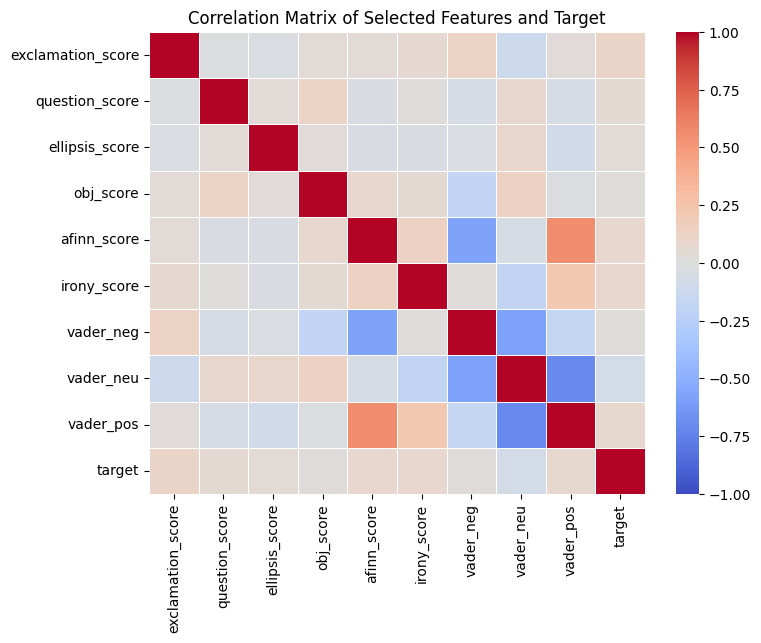

In [35]:
# add new cms for selected features correlation

correlation_data = processed_data[to_keep + ['target']]

# Compute correlation matrix
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features and Target')
plt.show()